In [1]:
import os
from binance.client import Client
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

## The Automatic Correlated Coin List (TACCL)

This script will allow you to build a list of correlated coins around a coin of your choice. You will need: 

1. A binance API Key
2. A chosen Bridge coin (Default USDT)
3. A chosen start coin (Default QUMT)

The script will do the rest. This is not a trading recommendation. Trading is risky, do not trade with money you cannot afford to lose. 

#### Basic strategy: 

This script will gather the data for all coin pairs available for your bridge coin. It will sequentially choose coins that maximise the sum of the correlations. This heuristic should pick a good list of co-related coins. 

## Usage Instructions

Run every line of the script. The final two boxes will display the recommended coin list and the heatmap of the rolling average for the last 24 hours.

In [2]:
api_key = ENTER YOUR API KEY HERE
api_secret = ENTER YOUR API KEY HERE
client = Client(api_key, api_secret)

In [3]:
def get_ticker_price(ticker_symbol: str, days:int , granularity:str):
    """
    Gets ticker price of a specific coin
    """

    target_date = (datetime.now() -timedelta(days = days)).strftime("%d %b %Y %H:%M:%S")
    key = f"{ticker_symbol}"
    end_date = datetime.now() 
    end_date = end_date.strftime("%d %b %Y %H:%M:%S")
    
    coindata = pd.DataFrame(columns = [key])
    
    prices = []
    dates = []
    for result in client.get_historical_klines(
        ticker_symbol, granularity, target_date, end_date, limit=1000
        ):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%d %b %Y %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates

    return(coindata.reindex(columns =['date',key]))

In [8]:
def get_price_data(tickers, window = 1, granularity = "1m"):
    '''
    Collects price data from the binance server.
    '''
    failures = []
    coindata = get_ticker_price(tickers[0], window, granularity)
    for tick in tickers[1:]:
        newdata = get_ticker_price(tick, window, granularity)
        if not newdata.empty:
            coindata = pd.merge(coindata, newdata)
        else:
            failures.append(tick)
    print('The following coins do not have historical data')
    print(failures)
    return(coindata)

In [22]:
def take_rolling_average(coindata):

    RA = pd.DataFrame()

    for column in coindata:
        if column != 'date':
            RA[column] = coindata[column].rolling(window=3).mean()
    return(RA)

In [18]:
def pick_coins(start_ticker , day_corr , week_corr, two_week_corr, n):
    '''
    Takes your starting coin, then sequentially picks the coin that jointly maximises
    the correlation for the whole coin list.
    
    INPUT:
    start_ticker : STR : The ticker for a coin you wish to include in your list
    day_corr     : PD.CORR : daily correlation data
    week_corr    : PD.CORR : Weekly correlation data
    two_week_corr: PD.CORR : bi-weekly correlation data
    n            : INTEGER : number of coins to include in your list.
    '''
    
    coinlist = [start_ticker]
    for i in range(n-1):    
        new_day_corr = day_corr[~day_corr.index.isin(coinlist)]
        new_week_corr = week_corr[~week_corr.index.isin(coinlist)]
        new_two_week_corr = two_week_corr[~two_week_corr.index.isin(coinlist)]
        corrsum = pd.DataFrame()
        for coin in coinlist:
            if corrsum.empty:
                corrsum = new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
            else:
                corrsum += new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
                
        ind = corrsum.argmax()
        coinlist.append(new_day_corr.index[ind])
    return(coinlist)

# Choose your Bridge coin and Starting coin here

In [25]:
bridge = 'USDT'
startcoin = 'BNT'
size_of_list = 20

In [26]:
client = Client(api_key, api_secret)

# Download ALL the coinpairs from binance
exchange_info = client.get_exchange_info()

full_coin_list = [] 

# Only keep the pairs to our bridge coin
for s in exchange_info['symbols']:
    if s['symbol'].endswith(bridge):
        full_coin_list.append(s['symbol'][:-4])

# List of words to eliminate futures markets coins
forbidden_words = ['DOWN','UP','BULL','BEAR']
for forbidden in forbidden_words:
    full_coin_list = [word for word in full_coin_list if forbidden not in word]

#Alphabetical order because pretty :)
full_coin_list.sort()

In [27]:
# Collect the data for 3 different windows (1 day, 1 week, 2 weeks)
# with granularity (1 minute, 1 hour ,2 hours)

cointickers = [coin+ bridge for coin in full_coin_list]
day_data = get_price_data(cointickers, 1, "1m")
week_data = get_price_data(cointickers, 7, "1h")
two_week_data = get_price_data(cointickers, 14, "2h")

The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']
The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']
The following coins do not have historical data
['BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BKRWUSDT', 'DAIUSDT', 'ERDUSDT', 'HCUSDT', 'LENDUSDT', 'MCOUSDT', 'NPXSUSDT', 'STORMUSDT', 'STRATUSDT', 'USDSUSDT', 'USDSBUSDT', 'VENUSDT', 'XZCUSDT']


In [28]:
day_data = day_data[day_data.columns.difference(['date'])].pct_change()
week_data = week_data[week_data.columns.difference(['date'])].pct_change()
two_week_data = two_week_data[two_week_data.columns.difference(['date'])].pct_change()

In [29]:
# Calculate the rolling average (RA3) for all the coins 

RA_day_data = take_rolling_average(day_data)
RA_week_data = take_rolling_average(week_data)
RA_2week_data = take_rolling_average(two_week_data)

In [181]:
# take the correlations of the rolling averages.
 
day_corr = RA_day_data.corr()
week_corr = RA_week_data.corr()
two_week_corr = RA_2week_data.corr()

coinlist = pick_coins(startcoin + bridge, day_corr , week_corr , two_week_corr , size_of_list )

In [178]:
# calculate stds
scaled_day_data = (day_data  / day_data.max())
scaled_week_data = (week_data  / week_data.max()) 
scaled_two_week_data = (two_week_data  / two_week_data.max())

day_std = scaled_day_data.std()
week_std = scaled_week_data.std()
two_week_std = scaled_two_week_data.std()

## Looking for volatility in the coinlist
Volatility in the market can be useful for your strategy, but large overwhelming jumps show an unpredictability (or an underlying cause) you should be wary of and investigate.  

These histograms show the maximum jumps taken over a day period (checked per minute) and two weeks (checked per hour). If a coin shows huge volatility you may choose to exclude it from your coin list

Top 10 daily maximum jumps
YFIUSDT     0.018916
LINKUSDT    0.017672
XMRUSDT     0.017642
LTCUSDT     0.016574
UNIUSDT     0.015915
BNBUSDT     0.013895
ETHUSDT     0.010550
BTCUSDT     0.010255
dtype: float64
Top 10 two weekly maximum jumps
YFIUSDT    0.064949
XTZUSDT    0.063275
LTCUSDT    0.060579
XMRUSDT    0.049985
BNBUSDT    0.048704
BNTUSDT    0.047977
BTCUSDT    0.046268
ETHUSDT    0.044820
dtype: float64


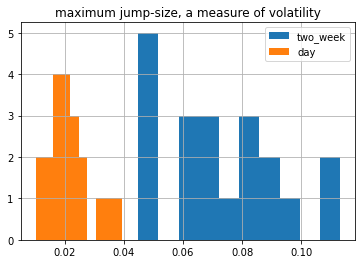

In [179]:
maxjumpday = day_data.max() - day_data.min()
maxjumptwoweek = two_week_data.max() - two_week_data.min()
maxjumptwoweek[coinlist].hist(label='two_week')
maxjumpday[coinlist].hist(label='day')
plt.title('maximum jump-size, a measure of volatility')
plt.legend()
print('Top 10 daily maximum jumps')
print(maxjumpday[coinlist].sort_values(ascending=False)[-8:])
print('Top 10 two weekly maximum jumps')
print(maxjumptwoweek[coinlist].sort_values(ascending=False)[-8:])

# TACCL result: 

This list is not a recommended trading list. Do not risk money if you are not sure what you are doing. 

In [180]:
coins = [coin.replace(bridge,'') for coin in coinlist]
for coin in coins:
    print(coin)

BNT
UNI
ETH
BTC
LTC
ONT
OMG
XTZ
MANA
CHZ
ENJ
XMR
BNB
REEF
LINK
GRT
1INCH
ALPHA
YFI
REN


The rest of the code will plot the correlation matric for the rolling average of the selected coins.

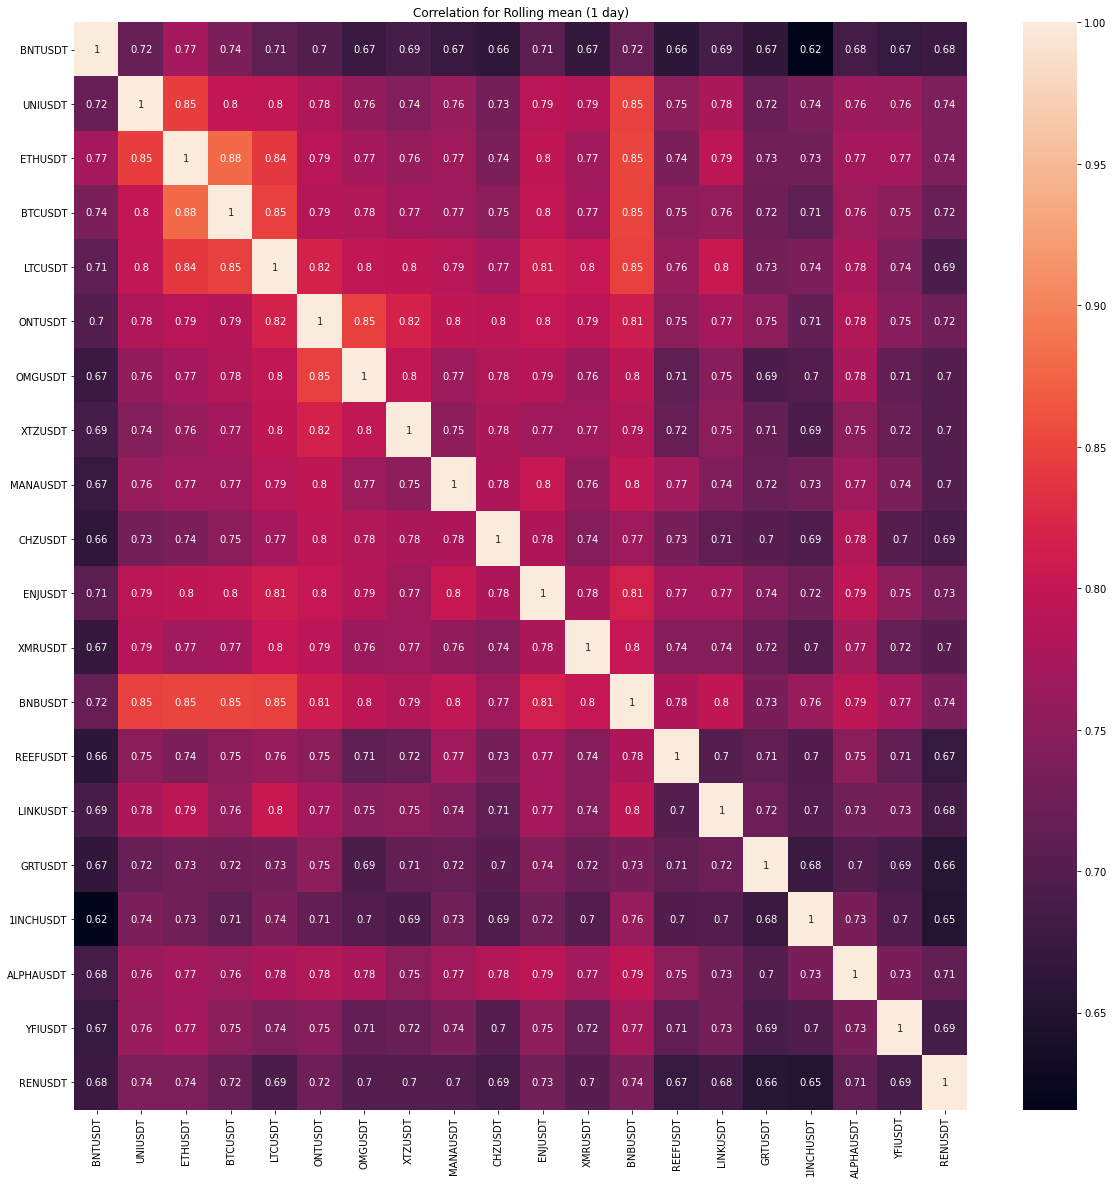

In [186]:
### Examine the trend of the rolling average
corrMatrixday = day_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixday, annot=True)
plt.title('Correlation for Rolling mean (1 day)')
plt.show()

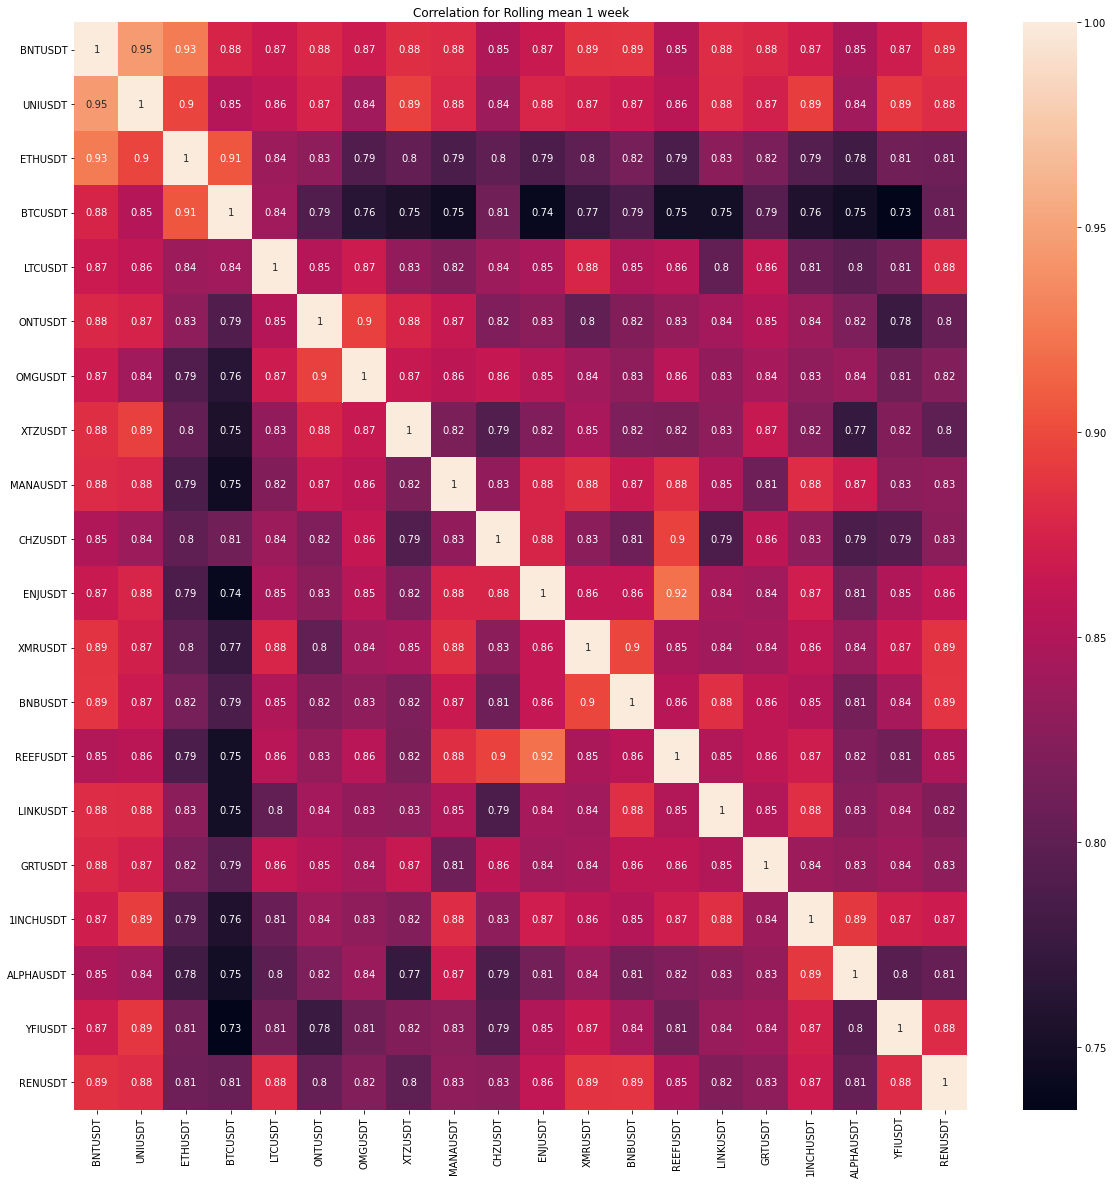

In [187]:
### Examine the trend of the rolling average
corrMatrixweek = week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixweek, annot=True)
plt.title('Correlation for Rolling mean 1 week')
plt.show()

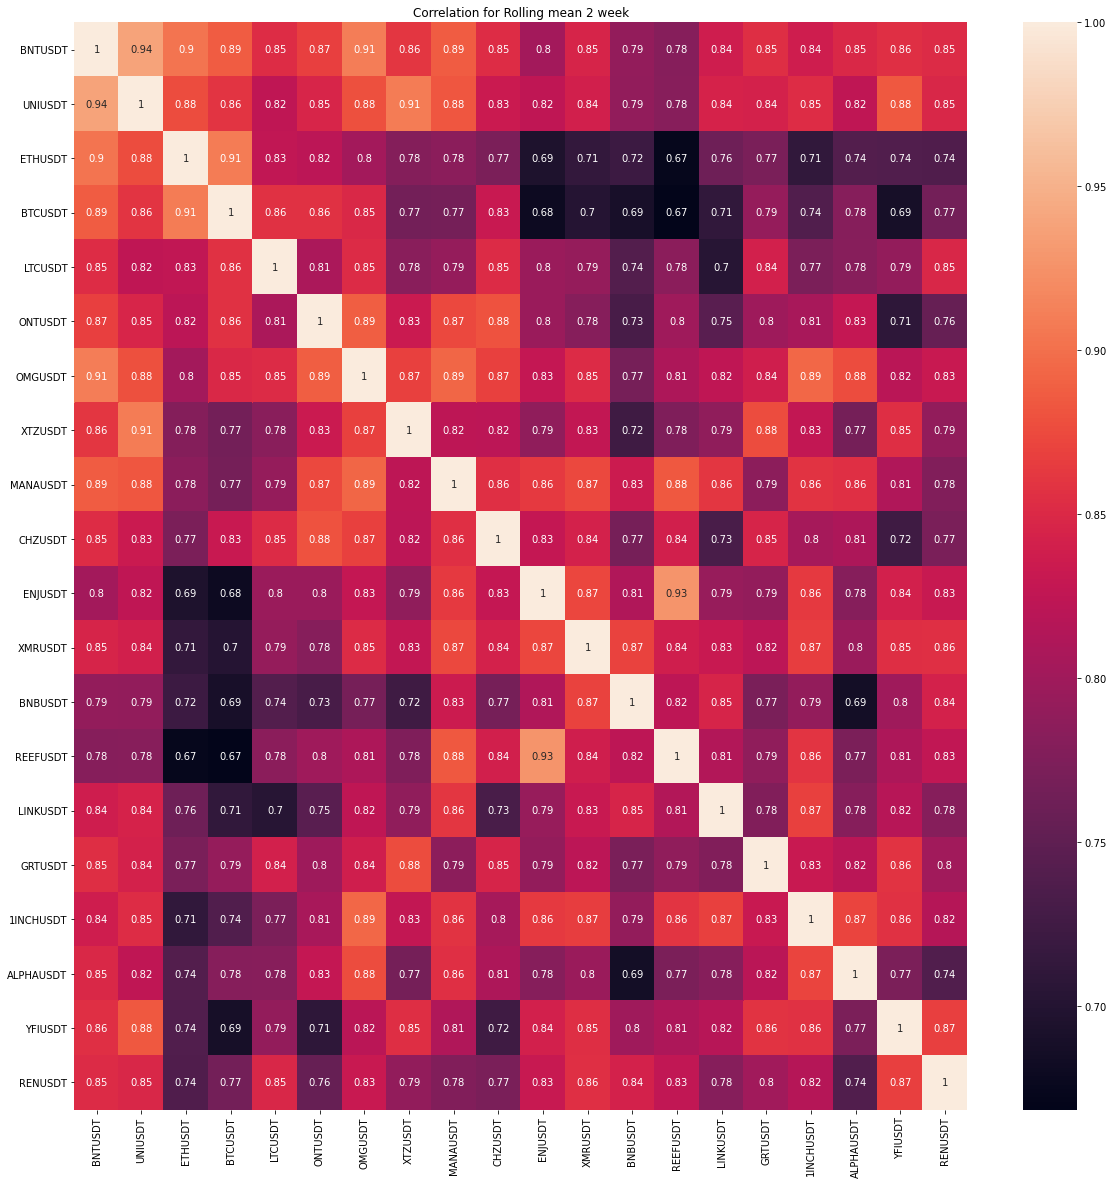

In [188]:
corrMatrixtwoweek = two_week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixtwoweek, annot=True)
plt.title('Correlation for Rolling mean 2 week')
plt.show()

In [43]:
# Grab coin prices from binance server 

### Set Period here ###
num_days = 10
###

#Create initial df with first coin then fill with all from list

coindata = get_ticker_price(coinlist[0],num_days , "1h")
for tick in coinlist[1:]:
    newdata = get_ticker_price(tick,num_days , "1m")
    coindata = pd.merge(coindata, newdata)

## Notes on correlation
For the Reverse Greedy Strategy you would like to see good long/mid-term correlation (a high number for the week and two-week) and a slightly lower correlation value for the daily. This implies you have a strong general trend but with noise to allow trading.

In [191]:
print(f"Day Correlation avg: {corrMatrixday.values[np.triu_indices_from(corrMatrix.values,1)].mean()}")
print(f"Week Correlation avg: {corrMatrixweek.values[np.triu_indices_from(corrMatrix.values,1)].mean()}")
print(f"Two Week Correlation avg: {corrMatrixtwoweek.values[np.triu_indices_from(corrMatrix.values,1)].mean()}")

Day Correlation avg: 0.7483091800492775
Week Correlation avg: 0.8398127249368459
Two Week Correlation avg: 0.8135300495944121


## Trade Volume

A coin that trades less frequently is more likely to suffer from slippage (a difficulty in transacting away from a position in time to make profit) You should consider this when accepting a coin list

This script identifies if any of the coins in your list trade under 5million USD in the previous 24 hour period

In [212]:
volumedata = client.get_ticker()

for data in volumedata:
    if data['symbol'] in coinlist:
        usdtradevol = float(data['volume'])*float(data['weightedAvgPrice'])
        print(data['symbol'] ,' 24hr trade volume is ' , usdtradevol,'USD')
        if usdtradevol<5E+6:
            print('Warning, low trade volumes can increase the probability of slippage')

BTCUSDT  24hr trade volume is  2718303950.6289563 USD
ETHUSDT  24hr trade volume is  2522576532.2961836 USD
BNBUSDT  24hr trade volume is  826714955.0518326 USD
LTCUSDT  24hr trade volume is  136939162.99460626 USD
ONTUSDT  24hr trade volume is  36899073.15322894 USD
LINKUSDT  24hr trade volume is  268754235.4801918 USD
XMRUSDT  24hr trade volume is  27100421.02727964 USD
OMGUSDT  24hr trade volume is  40812823.37116251 USD
ENJUSDT  24hr trade volume is  32160087.426417585 USD
CHZUSDT  24hr trade volume is  115625075.04094374 USD
XTZUSDT  24hr trade volume is  27162209.844792996 USD
RENUSDT  24hr trade volume is  51104872.81066488 USD
BNTUSDT  24hr trade volume is  9202121.608007351 USD
MANAUSDT  24hr trade volume is  32323206.834690258 USD
YFIUSDT  24hr trade volume is  23610371.633431356 USD
UNIUSDT  24hr trade volume is  122580746.00226091 USD
ALPHAUSDT  24hr trade volume is  26780984.01402811 USD
GRTUSDT  24hr trade volume is  139316931.95861834 USD
1INCHUSDT  24hr trade volume is 